## Book recomendation system using similarity

### Load the data files

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [34]:
from skhelper import *

In [35]:
# Load User Info
users = pd.read_csv('BX-Users.csv', error_bad_lines= False ,
                    warn_bad_lines = False,  encoding='iso-8859-1', delimiter = ';')

In [36]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [37]:
type(users)

pandas.core.frame.DataFrame

In [38]:
users.columns.values

array(['User-ID', 'Location', 'Age'], dtype=object)

In [39]:
# Load Book Information
books = pd.read_csv('BX-Books.csv', error_bad_lines= False ,
                    warn_bad_lines = False,  encoding='iso-8859-1', delimiter = ';')

In [40]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...


In [41]:
#Load Rating Information
ratings = pd.read_csv('BX-Book-Ratings.csv', error_bad_lines= False , 
                    warn_bad_lines = False,  encoding='iso-8859-1', delimiter = ';')

In [42]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0


In [43]:
ratings.isna().any()

User-ID        False
ISBN           False
Book-Rating    False
dtype: bool

In [44]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [45]:
len(ratings)

1149780

In [46]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [47]:
ratings = pd.merge(ratings, books[['Book-Title','ISBN']] ,on ='ISBN', how = 'left')

In [49]:
ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,276726,0155061224,5,Rites of Passage
2,276727,0446520802,0,The Notebook
3,276729,052165615X,3,Help!: Level 1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...


In [50]:
ratings =ratings.dropna(subset=['Book-Title'])

In [51]:
ratings.isna().any()

User-ID        False
ISBN           False
Book-Rating    False
Book-Title     False
dtype: bool

In [52]:
ratings = ratings.drop('ISBN', axis =1 )

In [53]:
ratings.head()

,User-ID,Book-Rating,Book-Title
0,276725,0,Flesh Tones: A Novel
1,276726,5,Rites of Passage
2,276727,0,The Notebook
3,276729,3,Help!: Level 1
4,276729,6,The Amsterdam Connection : Level 4 (Cambridge ...


In [54]:
len(ratings)

1031136

## Explorartory Data Analysis

### Plot the counts of each rating

In [17]:
# counts of each rating from ratings.

In [55]:
df = pd.DataFrame(ratings.groupby('Book-Rating').size(), columns=['count'])

In [56]:
df

,count
Book-Rating,
0,647294
1,1481
2,2375
3,5118
4,7617
5,45355
6,31687
7,66402
8,91804


### The count for zero rating score is too big to compare with others.  Log transformations for count values to plot and compare

In [57]:
df['log_count'] = np.log(df['count'])

In [58]:
# Creating a new df to plot the values 
df1 =  df.copy()

In [59]:
 df1 =df1.reset_index()

Text(0, 0.5, 'number of ratings')

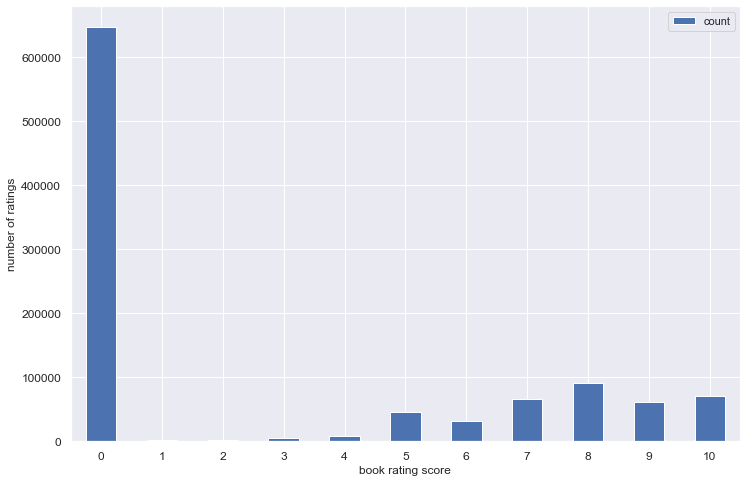

In [60]:
ax = df1.plot.bar( x='Book-Rating', y='count', rot = 0, figsize=(12, 8), fontsize = 12)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")

## It is evident that users have provided  rating score of mostly 0 followed by 8

### Ploting rating frequency of each book

In [61]:
PopularBooks = pd.DataFrame({'Count': ratings.groupby('Book-Title').size()}).sort_values('Count', ascending=False)

In [62]:
PopularBooks.head()

,Count
Book-Title,
Wild Animus,2502
The Lovely Bones: A Novel,1295
The Da Vinci Code,898
A Painted House,838
The Nanny Diaries: A Novel,828


Text(0, 0.5, 'number of ratings (log scale)')

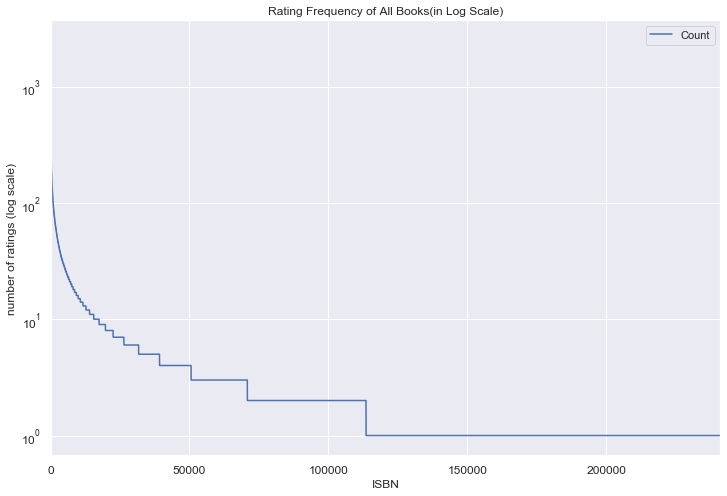

In [63]:
ax = PopularBooks \
    .sort_values('Count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books(in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("ISBN")
ax.set_ylabel("number of ratings (log scale)")

In [64]:
print("Total Books in the sample  :" , len(PopularBooks))

Total Books in the sample  : 241071


In [65]:
PopularBooks['Count'].quantile(np.arange(1, 0.5, -0.05))

1.00    2502.0
0.95      13.0
0.90       7.0
0.85       5.0
0.80       4.0
0.75       3.0
0.70       2.0
0.65       2.0
0.60       2.0
0.55       2.0
Name: Count, dtype: float64

### It is evident that out of 241071 books,  almost 10000 books have been rated less than 10 times. Very few books have been rated more than 100 times.

### Data preparation for recommendation system

## As per the above analysis, it is essential to train the dataset with only active users and frequently rated books 

In [66]:
# Creating dataframe with only frequently rated books 


PopularBooks = PopularBooks[PopularBooks.Count >= 190]

In [67]:
len(PopularBooks)

329

In [68]:
PopularBooks = PopularBooks.reset_index()

In [69]:
PopularBooks.head()

,Book-Title,Count
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828


In [72]:
PopularBooks['Book-Title'].nunique()

329

In [73]:
# Creating a copy of the popularbooks dataframe 
df1 = PopularBooks.copy()

In [74]:
PopularBooks=PopularBooks.drop('Count', axis =1)

In [75]:
PopularBooks.head()

,Book-Title
0,Wild Animus
1,The Lovely Bones: A Novel
2,The Da Vinci Code
3,A Painted House
4,The Nanny Diaries: A Novel


In [77]:
PopularBooks['Book-Title'].nunique()

329

In [78]:
PopularBooks =PopularBooks.merge(ratings, left_on='Book-Title', right_on='Book-Title', how = 'inner')

In [79]:
PopularBooks.head()

,Book-Title,User-ID,Book-Rating
0,Wild Animus,276925,0
1,Wild Animus,276939,0
2,Wild Animus,276954,0
3,Wild Animus,277042,2
4,Wild Animus,277157,0


In [80]:
len(PopularBooks)

105467

### Creating a dataframe with active users

In [81]:
data = pd.DataFrame({'Count': ratings.groupby('User-ID').size()}).sort_values('Count', ascending=False)

In [82]:
data.head()

,Count
User-ID,
11676,11144
198711,6456
153662,5814
98391,5779
35859,5646


In [83]:
data = data[data.Count >= 2200]

In [84]:
data.Count.nunique()

26

In [85]:
data = data.drop('Count', axis =1)

In [86]:
PopularUsers  =data.merge(ratings, left_on='User-ID', right_on='User-ID', how = 'inner')

In [87]:
PopularUsers.head()

,User-ID,Book-Rating,Book-Title
0,11676,0,Autumn Story Brambly Hedge
1,11676,0,Red Shift
2,11676,0,THE COAL HOUSE T/PB
3,11676,0,Glue (First Facts - First Skills)
4,11676,0,Little Grey Rabbit's Christmas (Collins Colour...


### Creating a dataframe with books with books which are rated most number of times

In [88]:
 datafinal =pd.DataFrame({'Size' :PopularUsers.groupby('Book-Title').size()}).sort_values('Size', ascending =False)

In [89]:
 datafinal.head()

,Size
Book-Title,
The Notebook,25
When the Wind Blows,25
Breathing Lessons,23
The Pelican Brief,23
Bridget Jones's Diary,22


In [90]:
 datafinal =  datafinal[ datafinal.Size >= 10]

In [91]:
len(datafinal)

415

In [92]:
 datafinal = datafinal.drop('Size', axis =1)

In [93]:
PopularUsers  =data.merge(ratings, left_on='User-ID', right_on='User-ID', how = 'inner')

### Final dataframe with popular books with high rating and active users

In [94]:
final = datafinal.merge(PopularUsers,left_on='Book-Title', right_on='Book-Title', how = 'inner')

In [95]:
len(final)

5260

In [118]:
final

,Book-Title,User-ID,Book-Rating
0,The Notebook,11676,10
1,The Notebook,11676,6
2,The Notebook,11676,10
3,The Notebook,198711,0
4,The Notebook,153662,0
5,The Notebook,35859,0
6,The Notebook,278418,0
7,The Notebook,278418,0
8,The Notebook,76352,0
9,The Notebook,76352,0


In [99]:
final['Book-Title'].nunique()

415

In [100]:
final['User-ID'].nunique()

26

### Creating a pivot table 

In [101]:
df3 = final.pivot_table(index=['User-ID'],columns=['Book-Title'],values='Book-Rating')

In [102]:
df3.head()

Book-Title,1st to Die: A Novel,2nd Chance,A Bend in the Road,A Case of Need,A Civil Action,A Darkness More Than Night,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Painted House,A Prayer for Owen Meany,A Time to Kill,...,While I Was Gone,"Whirlwind (Tyler, Book 1)",Whispers,White Oleander : A Novel,Wild Animus,Windmills of the Gods,Wings,Winter Moon,Wuthering Heights,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
11676,9.0,7.5,6.5,9.0,3.5,4.5,0.0,9.0,10.0,0.0,...,4.0,0.0,4.666667,9.0,6.0,3.0,8.0,10.0,3.333333,3.5
16795,9.0,0.0,8.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,4.500000,8.5,0.0,NaN,0.0,0.0,NaN,NaN
35859,7.0,7.5,0.0,3.0,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,4.000000,0.0,0.0,NaN,0.0,0.0,NaN,NaN
36836,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
52584,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.000000,NaN,NaN,5.0,0.0,0.0,NaN,NaN


In [103]:
# Removing Nan values in the pivot table
df3 = df3.fillna(value = 0 , axis = 0)

In [104]:
df3.head()

Book-Title,1st to Die: A Novel,2nd Chance,A Bend in the Road,A Case of Need,A Civil Action,A Darkness More Than Night,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Painted House,A Prayer for Owen Meany,A Time to Kill,...,While I Was Gone,"Whirlwind (Tyler, Book 1)",Whispers,White Oleander : A Novel,Wild Animus,Windmills of the Gods,Wings,Winter Moon,Wuthering Heights,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
11676,9.0,7.5,6.5,9.0,3.5,4.5,0.0,9.0,10.0,0.0,...,4.0,0.0,4.666667,9.0,6.0,3.0,8.0,10.0,3.333333,3.5
16795,9.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.500000,8.5,0.0,0.0,0.0,0.0,0.000000,0.0
35859,7.0,7.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
36836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
52584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,5.0,0.0,0.0,0.000000,0.0


In [105]:
# Creating a standardized dataset
standardizedata  = standardizeRow(df3)

In [106]:
standardizeTransdata = standardizedata.T

In [107]:
standardizeTransdata =standardizeTransdata.dropna()

In [108]:
standardizeTransdata

User-ID,11676,16795,35859,36836,52584,55492,60244,76352,98391,98741,...,198711,204864,212898,227447,230522,232131,234623,235105,245963,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0.876068,0.876068,0.653846,-0.123932,-0.123932,-0.123932,-0.123932,-0.123932,-0.123932,-0.123932,...,-0.123932,-0.123932,-0.123932,-0.123932,-0.123932,0.320513,-0.123932,-0.123932,-0.123932,-0.123932
2nd Chance,0.692308,-0.141026,0.692308,-0.141026,-0.141026,-0.141026,-0.141026,-0.141026,0.858974,-0.141026,...,-0.141026,0.858974,-0.141026,-0.141026,-0.141026,-0.141026,-0.141026,-0.141026,-0.141026,-0.141026
A Bend in the Road,0.704327,0.891827,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,0.891827,-0.108173,...,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173,-0.108173
A Case of Need,0.948718,-0.051282,0.282051,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,...,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282,-0.051282
A Civil Action,0.961538,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,...,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462
A Darkness More Than Night,0.367308,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,...,-0.082692,0.917308,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692,-0.082692
A Painted House,0.961538,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,...,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462
A Prayer for Owen Meany,0.892308,-0.107692,-0.107692,-0.107692,-0.107692,-0.107692,-0.107692,-0.107692,-0.107692,-0.107692,...,-0.107692,0.792308,-0.107692,-0.107692,-0.107692,0.792308,-0.107692,-0.107692,-0.107692,-0.107692
A Time to Kill,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,...,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462,-0.038462


### Importing cosine similarity

In [109]:
from sklearn.metrics.pairwise import cosine_similarity

In [110]:
book_to_book_similarity = cosine_similarity(standardizeTransdata)

In [111]:
book_to_book_similarity

array([[ 1.        ,  0.39096012,  0.61525444, ...,  0.57632265,
         0.04369314,  0.57632265],
       [ 0.39096012,  1.        ,  0.49227214, ...,  0.41661904,
        -0.00440991,  0.41661904],
       [ 0.61525444,  0.49227214,  1.        , ...,  0.46796216,
         0.02760464,  0.46796216],
       ...,
       [ 0.57632265,  0.41661904,  0.46796216, ...,  1.        ,
         0.21665981,  1.        ],
       [ 0.04369314, -0.00440991,  0.02760464, ...,  0.21665981,
         1.        ,  0.21665981],
       [ 0.57632265,  0.41661904,  0.46796216, ...,  1.        ,
         0.21665981,  1.        ]])

In [112]:
book_to_book_similarityDataFrame = pd.DataFrame(book_to_book_similarity ,index=standardizeTransdata.index,
                                                columns=standardizeTransdata.index)

In [113]:
book_to_book_similarityDataFrame

Book-Title,1st to Die: A Novel,2nd Chance,A Bend in the Road,A Case of Need,A Civil Action,A Darkness More Than Night,A Painted House,A Prayer for Owen Meany,A Time to Kill,A Walk to Remember,...,Where the Red Fern Grows,While I Was Gone,Whispers,White Oleander : A Novel,Wild Animus,Windmills of the Gods,Wings,Winter Moon,Wuthering Heights,"\O\"" Is for Outlaw"""
Book-Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,1.000000,0.390960,0.615254,0.691112,0.576323,0.096204,0.576323,0.446104,-0.081529,0.831437,...,-0.173819,0.576323,0.560929,0.637009,0.576323,0.230713,0.576323,0.576323,0.043693,0.576323
2nd Chance,0.390960,1.000000,0.492272,0.533426,0.416619,0.513890,0.416619,0.518716,-0.084867,0.250264,...,0.139815,0.416619,0.705087,0.154241,0.416619,0.144143,0.416619,0.416619,-0.004410,0.416619
A Bend in the Road,0.615254,0.492272,1.000000,0.426368,0.467962,0.070433,0.467962,0.218053,-0.071871,0.762247,...,-0.153230,0.467962,0.885323,0.585889,0.467962,0.182383,0.467962,0.467962,0.027605,0.467962
A Case of Need,0.691112,0.533426,0.426368,1.000000,0.947473,0.270333,0.947473,0.550801,-0.051215,0.668327,...,-0.109190,0.947473,0.434525,0.519789,0.947473,0.451595,0.947473,0.947473,0.186795,0.947473
A Civil Action,0.576323,0.416619,0.467962,0.947473,1.000000,0.304356,1.000000,0.597629,-0.040000,0.715209,...,-0.085280,1.000000,0.354883,0.565359,1.000000,0.488901,1.000000,1.000000,0.216660,1.000000
A Darkness More Than Night,0.096204,0.513890,0.070433,0.270333,0.304356,1.000000,0.304356,0.596838,-0.068520,0.178266,...,0.295567,0.304356,0.019793,0.460486,0.304356,0.099608,0.304356,0.304356,-0.012274,0.304356
A Painted House,0.576323,0.416619,0.467962,0.947473,1.000000,0.304356,1.000000,0.597629,-0.040000,0.715209,...,-0.085280,1.000000,0.354883,0.565359,1.000000,0.488901,1.000000,1.000000,0.216660,1.000000
A Prayer for Owen Meany,0.446104,0.518716,0.218053,0.550801,0.597629,0.596838,0.597629,1.000000,-0.072128,0.393699,...,0.167507,0.597629,0.136588,0.280392,0.597629,0.250081,0.597629,0.597629,0.062542,0.597629
A Time to Kill,-0.081529,-0.084867,-0.071871,-0.051215,-0.040000,-0.068520,-0.040000,-0.072128,1.000000,-0.057706,...,-0.085280,-0.040000,-0.079327,-0.072202,-0.040000,-0.055874,-0.040000,-0.040000,-0.066413,-0.040000


In [114]:
def getRecommendationonBook(mName,uRating):
    meanRating = (0+5)/2
    similarScoring = book_to_book_similarityDataFrame[mName]*(uRating - meanRating)
    return similarScoring.sort_values(ascending=False)


In [116]:
RecommendationUser1 = getRecommendationonBook('The Notebook',10)

In [117]:
RecommendationUser1 

Book-Title
The Notebook                                                           7.500000
Icy Sparks                                                             7.233224
Circle of Friends                                                      7.226420
Summer Sisters                                                         7.223414
Blessings                                                              7.215096
Mirror Image                                                           7.215096
Fear Nothing                                                           7.213413
Along Came a Spider (Alex Cross Novels)                                7.213413
The Rainmaker                                                          7.213413
Critical Judgment                                                      7.213413
Cradle and All                                                         7.202483
Five Days in Paris                                                     7.200384
A Walk to Remember           

In [119]:
newUser = [('Flashback',8),('Body of Lies',8)]

In [120]:
RecommendationforNewUser = pd.DataFrame()
for mName, uRating in newUser:
    RecommendationforNewUser = RecommendationforNewUser.append(getRecommendationonBook(mName,uRating),ignore_index = True)

In [121]:
RecommendationforNewUser


,1st to Die: A Novel,2nd Chance,A Bend in the Road,A Case of Need,A Civil Action,A Darkness More Than Night,A Painted House,A Prayer for Owen Meany,A Time to Kill,A Walk to Remember,...,Where the Red Fern Grows,While I Was Gone,Whispers,White Oleander : A Novel,Wild Animus,Windmills of the Gods,Wings,Winter Moon,Wuthering Heights,"\O\"" Is for Outlaw"""
0,1.077784,2.050044,2.487197,1.117123,1.314417,-0.142643,1.314417,2.142469,-0.453247,0.659825,...,-0.966326,1.314417,2.843927,0.265509,1.314417,0.292819,1.314417,1.314417,-0.271408,1.314417
1,0.794999,2.984157,3.470783,1.902390,2.108897,0.236762,2.108897,0.913646,-0.383436,1.299104,...,-0.817488,2.108897,3.892422,0.835774,2.108897,0.769934,2.108897,2.108897,0.041746,2.108897


In [122]:
RecommendationforNewUser.sum()

1st to Die: A Novel                                               1.872783
2nd Chance                                                        5.034201
A Bend in the Road                                                5.957980
A Case of Need                                                    3.019513
A Civil Action                                                    3.423314
A Darkness More Than Night                                        0.094119
A Painted House                                                   3.423314
A Prayer for Owen Meany                                           3.056114
A Time to Kill                                                   -0.836683
A Walk to Remember                                                1.958929
A Widow for One Year                                             -0.836683
A Wrinkle in Time                                                 3.446993
Absolute Power                                                    3.423314
Accident                 

In [123]:
RecommendationforNewUser.sum().sort_values(ascending=False)

Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)    10.317997
Body of Lies                                                    10.050170
Flashback                                                       10.050170
Last Man Standing                                               10.025367
Mortal Prey                                                      9.794282
Q Is for Quarry                                                  9.765861
Over the Edge                                                    9.680498
Chasing the Dime                                                 9.523207
The Millionaires                                                 9.299070
Red Rabbit                                                       9.192823
The Oath                                                         8.926091
The Surgeon                                                      8.377212
Faking It                                                        8.086420
Daddy's Little Girl                   

### End of File